In [198]:
import pandas as pd 
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers, models
from keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add
from keras.models import Model
from pathlib import Path
from sklearn.preprocessing import StandardScaler


In [82]:
# Load TESS dataset
'''
def load_dataset(base_dir='TESS Toronto emotional speech set data'):
    labels_map = {
        'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3,
        'neutral': 4, 'ps': 5, 'sad': 6  # ps = pleasant surprise
    }
    X, y = [], []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.wav'):
                emotion = file.split('_')[-1].replace('.wav', '').lower()
                if emotion in labels_map:
                    mfcc = extract_mfcc(os.path.join(root, file))
                    X.append(mfcc)
                    y.append(labels_map[emotion])
    return np.array(X), np.array(y)
'''
paths = []
labels = []

data_dir = Path("TESS Toronto emotional speech set data")

for audio_file in data_dir.rglob("*.wav"):
    paths.append(str(audio_file))
    label = audio_file.name.split("_")[-1].split(".")[0]
    labels.append(label.lower())

print(f"Loaded {len(paths)} audio files with {len(labels)} labels")

Loaded 2800 audio files with 2800 labels


In [84]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

In [86]:
df.info

<bound method DataFrame.info of                                                  speech    label
0     TESS Toronto emotional speech set data/YAF_dis...  disgust
1     TESS Toronto emotional speech set data/YAF_dis...  disgust
2     TESS Toronto emotional speech set data/YAF_dis...  disgust
3     TESS Toronto emotional speech set data/YAF_dis...  disgust
4     TESS Toronto emotional speech set data/YAF_dis...  disgust
...                                                 ...      ...
2795  TESS Toronto emotional speech set data/OAF_Sad...      sad
2796  TESS Toronto emotional speech set data/OAF_Sad...      sad
2797  TESS Toronto emotional speech set data/OAF_Sad...      sad
2798  TESS Toronto emotional speech set data/OAF_Sad...      sad
2799  TESS Toronto emotional speech set data/OAF_Sad...      sad

[2800 rows x 2 columns]>

In [88]:
# ========== STEP 1: Load and Process Audio Files ==========
'''
def extract_mfcc(file_path, n_mfcc=40, max_pad_len=174):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    pad_width = max(0, max_pad_len - mfcc.shape[1])
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc.T  # shape: (174, 40)
'''

"\ndef extract_mfcc(file_path, n_mfcc=40, max_pad_len=174):\n    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')\n    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)\n    pad_width = max(0, max_pad_len - mfcc.shape[1])\n    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')\n    return mfcc.T  # shape: (174, 40)\n"

# MFCC feature extraction

In [129]:
def extract_mfcc(filename, n_mfcc=40, max_pad_len=174):
    y, sr = librosa.load(filename, sr=None, duration=2, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Pad or truncate to fixed size
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    
    return mfcc.T  # Final shape: (174, 40)

In [200]:
# Apply to entire dataset (returns list of (174, 40))
x_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

# Convert to array
x = np.array(x_mfcc.tolist())  # Shape: (num_samples, 174, 40)
# print("Final X shape:", x.shape)

In [206]:
#standardize the data
x_temp = x.reshape(-1, x.shape[2])  # Flatten to (num_samples * 174, 40)
scaler = StandardScaler()
x_temp = scaler.fit_transform(x_temp)
x = x_temp.reshape(x.shape)
print("Final X shape:", x.shape)

Final X shape: (2800, 174, 40)


In [114]:
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['label'] = df['label'].map(label_map)
df.head(10)

,speech,label
0,TESS Toronto emotional speech set data/YAF_dis...,0
1,TESS Toronto emotional speech set data/YAF_dis...,0
2,TESS Toronto emotional speech set data/YAF_dis...,0
3,TESS Toronto emotional speech set data/YAF_dis...,0
4,TESS Toronto emotional speech set data/YAF_dis...,0
5,TESS Toronto emotional speech set data/YAF_dis...,0
6,TESS Toronto emotional speech set data/YAF_dis...,0
7,TESS Toronto emotional speech set data/YAF_dis...,0
8,TESS Toronto emotional speech set data/YAF_dis...,0
9,TESS Toronto emotional speech set data/YAF_dis...,0


In [208]:
X, y = load_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# Building Model and Trained

In [211]:
def transformer_encoder(inputs, num_heads=8, ff_dim=128, dropout_rate=0.1):
    # Multi-Head Self-Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = Add()([inputs, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    # Feed-Forward Network
    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Dense(ff_dim, activation='linear')(ffn_output)
    out2 = Add()([out1, ffn_output])
    out2 = LayerNormalization(epsilon=1e-6)(out2)
    
    return out2

In [213]:
# Full hybrid model
def build_hybrid_model(input_shape, num_classes=7, dropout_rate=0.3):
    inputs = Input(shape=input_shape)

    # LSTM Layer
    x = LSTM(128, activation='tanh', return_sequences=True)(inputs)
    x = Dropout(dropout_rate)(x)

    # Transformer Encoder Block
    x = transformer_encoder(x, num_heads=8, ff_dim=128, dropout_rate=dropout_rate)

    # Second LSTM
    x = LSTM(64, activation='tanh', return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)

    # Dense classification head
    x = Dense(32, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [215]:
# Instantiate and inspect
model = build_hybrid_model(input_shape=(174, 40))
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 174, 40)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 174, 128)  │     86,528 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 174, 128)  │          0 │ lstm_20[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 174, 128)  │    527,488 │ dropout_50[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_50[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 174, 128)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 174, 128)  │          0 │ dropout_50[0][0], │
│                     │                   │            │ dropout_52[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 174, 128)  │        256 │ add_20[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 174, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 174, 128)  │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 174, 128)  │     16,512 │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 174, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 174, 128)  │        256 │ add_21[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 64)        │          0 │ lstm_21[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 32)        │      2,080 │ dropout_54[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 7)         │        231 │ dense_42[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 699,271 (2.67 MB)

 Trainable params: 699,271 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [217]:
model = build_hybrid_model(input_shape=(174, 40), num_classes=7)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [221]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=30, batch_size=16)


Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.3420 - loss: 1.6018 - val_accuracy: 0.7812 - val_loss: 0.6283
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.8125 - loss: 0.5771 - val_accuracy: 0.9598 - val_loss: 0.1364
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.9517 - loss: 0.1642 - val_accuracy: 0.9821 - val_loss: 0.0840
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.9890 - loss: 0.0604 - val_accuracy: 0.9777 - val_loss: 0.0951
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.9321 - loss: 0.2105 - val_accuracy: 0.9777 - val_loss: 0.0759
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.9550 - loss: 0.1615 - val_accuracy: 0.9911 - val_loss: 0.0446
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 190ms/step - accuracy: 0.9795 - loss: 0.0818 - val_accuracy: 0.9955 - val_loss: 0.0302
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - accuracy: 0.9868 - loss: 0

In [223]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step


In [225]:
print("Classification Report:\n", classification_report(y_test, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00        80
           3       1.00      1.00      1.00        80
           4       1.00      1.00      1.00        80
           5       1.00      1.00      1.00        80
           6       1.00      1.00      1.00        80

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560

Confusion Matrix:
 [[80  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0]
 [ 0  0 80  0  0  0  0]
 [ 0  0  0 80  0  0  0]
 [ 0  0  0  0 80  0  0]
 [ 0  0  0  0  0 80  0]
 [ 0  0  0  0  0  0 80]]


In [188]:
y_pred = model.predict(X_test)  # not predict_proba

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step


In [227]:
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred_classes.shape)

y_test shape: (560,)
y_pred shape: (560,)


In [170]:
import matplotlib.pyplot as plt

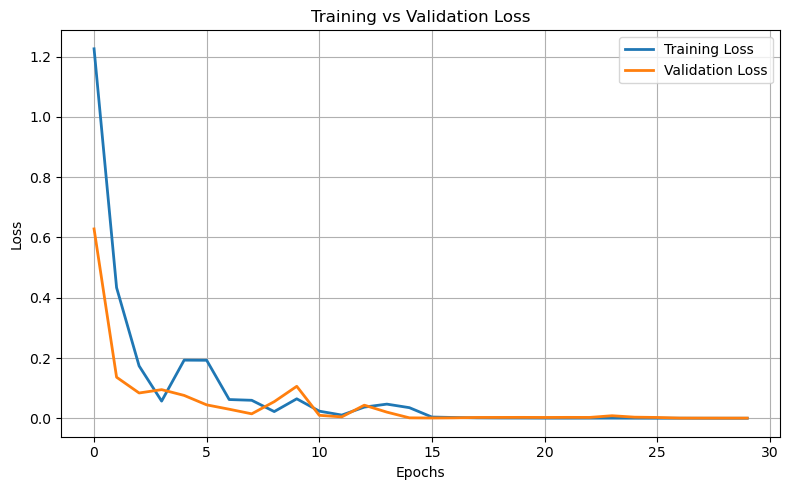

In [229]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save and Load the model

In [232]:
model.save("Emotion Detection Hybrid_Model.keras") 

In [236]:
from keras.models import load_model
model = load_model("Emotion Detection Hybrid_Model.keras")
#This restores the model to its exact state at the time of saving, allowing you to resume training or make predictions without additional setup. 

In [242]:
model.save_weights("Emotion Detection Hybrid_Model.weights.h5") #save only the model’s weights

In [244]:
#to load these weights into a model with the same architecture
model.load_weights("Emotion Detection Hybrid_Model.weights.h5") 

In [282]:
label_names = ['angry', 'disgust', 'fear', 'happy',
        'neutral', 'ps', 'sad']

In [284]:
predicted_labels = [label_names[i] for i in y_pred_classes]
for idx, label in zip(y_pred_classes, predicted_labels):
    print(f"Predicted class index: {idx} --> Label: {label}")

Predicted class index: 6 --> Label: sad
Predicted class index: 6 --> Label: sad
Predicted class index: 1 --> Label: disgust
Predicted class index: 0 --> Label: angry
Predicted class index: 1 --> Label: disgust
Predicted class index: 6 --> Label: sad
Predicted class index: 2 --> Label: fear
Predicted class index: 6 --> Label: sad
Predicted class index: 1 --> Label: disgust
Predicted class index: 5 --> Label: ps
Predicted class index: 5 --> Label: ps
Predicted class index: 2 --> Label: fear
Predicted class index: 5 --> Label: ps
Predicted class index: 3 --> Label: happy
Predicted class index: 4 --> Label: neutral
Predicted class index: 4 --> Label: neutral
Predicted class index: 0 --> Label: angry
Predicted class index: 1 --> Label: disgust
Predicted class index: 3 --> Label: happy
Predicted class index: 0 --> Label: angry
Predicted class index: 6 --> Label: sad
Predicted class index: 3 --> Label: happy
Predicted class index: 4 --> Label: neutral
Predicted class index: 0 --> Label: angry